# 0. GETTING STARTED

In [7]:
!pip install rdkit

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools, AllChem, rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import base64
import matplotlib.pyplot as plt
from io import BytesIO
%matplotlib inline
import numpy as np
import seaborn as sn
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.inspection import permutation_importance

# 1. TRAIN AND TEST SET 


In [9]:
#Morgan fingerprint

df_train = pd.read_csv('TrainQSAR.csv')
PandasTools.AddMoleculeColumnToFrame(df_train, 'SMILES', 'Molecule')

df_test = pd.read_csv('TestQSAR.csv')
PandasTools.AddMoleculeColumnToFrame(df_test, 'SMILES', 'Molecule')

def generate_fpts(data):
    Mfpts = []
    for mol in tqdm(data):
        mfpt = AllChem.GetMorganFingerprintAsBitVect(mol, 4, nBits=256)
        Mfpts.append(mfpt)

    return np.array(Mfpts)

mfpts_train = generate_fpts(df_train.Molecule)
mfpts_test = generate_fpts(df_test.Molecule)

100%|██████████| 329/329 [00:00<00:00, 5730.78it/s]


In [10]:
X_train = pd.DataFrame(mfpts_train)
X_test = pd.DataFrame(mfpts_test)
y_train = pd.DataFrame(df_train['pIC50'], columns=['pIC50'])
y_test = pd.DataFrame(df_test['pIC50'], columns=['pIC50'])

# 2. HYPERPARAMETER OPTIMIZATION

In [11]:
# Define the parameter grid for SVR
param_grid = {
    'C': [0.01,0.1,1,5,10],
    'epsilon': [0.01,0.05, 0.1,0.5,1],
    'kernel': ['rbf','poly','linear']
}

# Create the SVR model
svr = SVR()

# Perform grid search using cross-validation
grid_search = GridSearchCV(svr, param_grid, scoring='r2', cv = 3, verbose = 2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best SVR model
best_svr = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_test = best_svr.predict(X_test)
y_pred_train = best_svr.predict(X_train)

# Calculate R-squared scores
print("R-squared on test set:", r2_score(y_test, y_pred_test))
print("R-squared on train set:", r2_score(y_train, y_pred_train))

# Get the best parameters
print("Best parameters:", grid_search.best_params_)

Fitting 3 folds for each of 75 candidates, totalling 225 fits
[CV] END ...................C=0.01, epsilon=0.01, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.01, epsilon=0.01, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.01, epsilon=0.01, kernel=rbf; total time=   0.1s
[CV] END ..................C=0.01, epsilon=0.01, kernel=poly; total time=   0.0s
[CV] END ..................C=0.01, epsilon=0.01, kernel=poly; total time=   0.0s
[CV] END ..................C=0.01, epsilon=0.01, kernel=poly; total time=   0.0s
[CV] END ................C=0.01, epsilon=0.01, kernel=linear; total time=   0.0s
[CV] END ................C=0.01, epsilon=0.01, kernel=linear; total time=   0.0s
[CV] END ................C=0.01, epsilon=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, epsilon=0.05, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.01, epsilon=0.05, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.01, epsilon=0.0

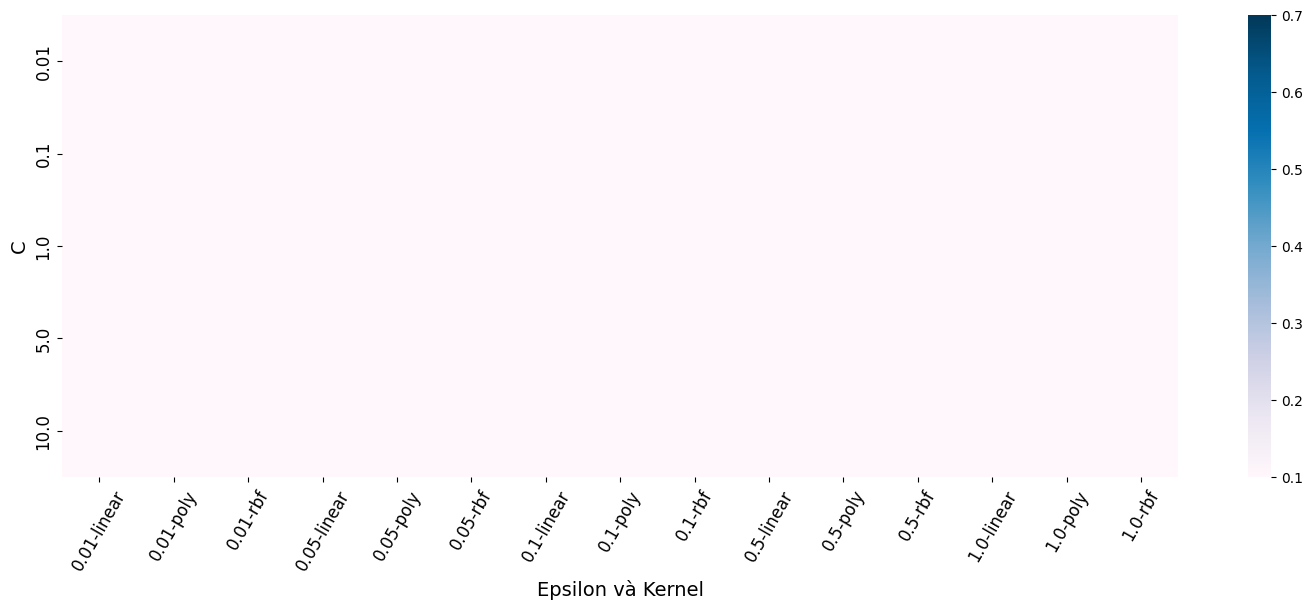

In [12]:
# Get the grid search results
results = grid_search.cv_results_

# Extract the parameters and scores
param_C = results['param_C'].data
param_epsilon = results['param_epsilon'].data
param_kernel = results['param_kernel'].data
mean_test_score = results['mean_test_score']

# Create a dataframe from the data
data = pd.DataFrame({'C': param_C, 'epsilon': param_epsilon, 'kernel': param_kernel, 'score': mean_test_score})

# Pivot the dataframe to create a matrix for the heatmap
matrix = data.pivot_table(index='C', columns=['epsilon', 'kernel'], values='score')

# Create the heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(matrix, cmap='PuBu', cbar=True, fmt='.10f', vmin = 0.1, vmax = 0.7)

# Set labels and title
plt.xlabel('Epsilon và Kernel', fontsize = 14)
plt.ylabel('C', fontsize = 14)
plt.xticks(rotation=60, fontsize = 12)
plt.yticks( fontsize = 12)
# plt.title('Kết Grid Search')

# Display the plot
plt.show()

In [13]:
# Define the parameter grid for SVR
param_grid1 = {
    'C': [1,2,3,4,5,6,7,8,9,10],
    'epsilon': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1],
    'kernel': ['poly','rbf']
}

# Create the SVR model
svr = SVR()

# Perform grid search using cross-validation
grid_search1 = GridSearchCV(svr, param_grid1, scoring='r2', cv = 3, verbose = 2)

# Fit the grid search to the training data
grid_search1.fit(X_train, y_train)

# Get the best SVR model
best_svr1 = grid_search1.best_estimator_

# Make predictions on the test set using the best model
y_pred_test = best_svr1.predict(X_test)
y_pred_train = best_svr1.predict(X_train)

# Calculate R-squared scores
print("R-squared on test set:", r2_score(y_test, y_pred_test))
print("R-squared on train set:", r2_score(y_train, y_pred_train))

# Get the best parameters
print("Best parameters:", grid_search1.best_params_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV] END .....................C=1, epsilon=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=1, epsilon=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=1, epsilon=0.01, kernel=poly; total time=   0.0s
[CV] END ......................C=1, epsilon=0.01, kernel=rbf; total time=   0.1s
[CV] END ......................C=1, epsilon=0.01, kernel=rbf; total time=   0.1s
[CV] END ......................C=1, epsilon=0.01, kernel=rbf; total time=   0.1s
[CV] END .....................C=1, epsilon=0.02, kernel=poly; total time=   0.0s
[CV] END .....................C=1, epsilon=0.02, kernel=poly; total time=   0.0s
[CV] END .....................C=1, epsilon=0.02, kernel=poly; total time=   0.0s
[CV] END ......................C=1, epsilon=0.02, kernel=rbf; total time=   0.1s
[CV] END ......................C=1, epsilon=0.02, kernel=rbf; total time=   0.1s
[CV] END ......................C=1, epsilon=0.

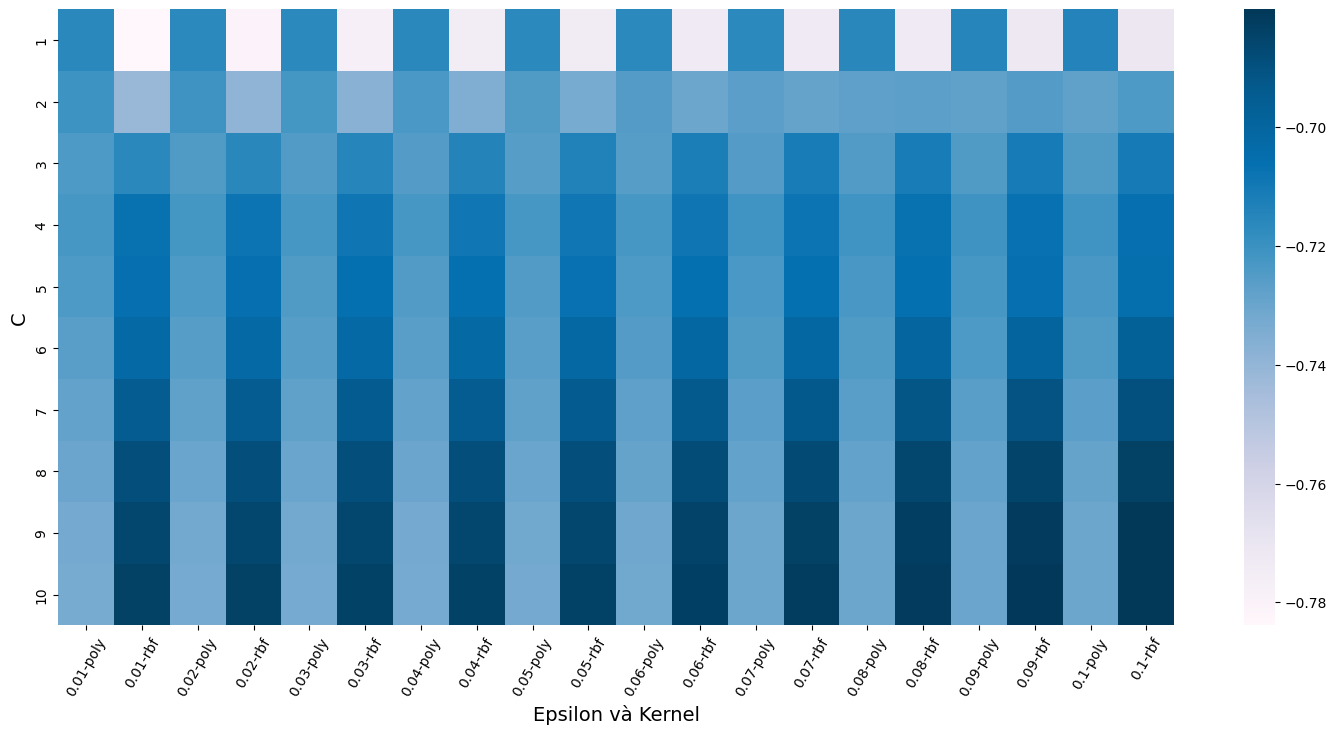

In [14]:
# Get the grid search results
results = grid_search1.cv_results_

# Extract the parameters and scores
param_C = results['param_C'].data
param_epsilon = results['param_epsilon'].data
param_kernel = results['param_kernel'].data
mean_test_score = results['mean_test_score']

# Create a dataframe from the data
data = pd.DataFrame({'C': param_C, 'epsilon': param_epsilon, 'kernel': param_kernel, 'score': mean_test_score})

# Pivot the dataframe to create a matrix for the heatmap
matrix = data.pivot_table(index='C', columns=['epsilon', 'kernel'], values='score')

# Create the heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(matrix, cmap='PuBu', cbar=True, fmt='.8f')

# Set labels and title
plt.xlabel('Epsilon và Kernel', fontsize = 14)
plt.ylabel('C', fontsize = 14)
plt.xticks(rotation=60)
# plt.title('Kết Grid Search')

# Display the plot
plt.show()

In [ ]:
baseline_svm = SVR()
model_params = {
    'C': uniform(loc=3, scale=1),
    'kernel': [ 'rbf'],
    'epsilon': uniform(loc=0.01, scale=0.1)
}
randomized_search = RandomizedSearchCV(estimator=baseline_svm, param_distributions=model_params, n_iter=100 , verbose = 2,
                                    cv=3)

randomized_search.fit(X_train, y_train)

In [ ]:
print("Random Score:", randomized_search.best_params_)
print("Random Score:", randomized_search.best_score_)

Random Score: {'C': 3.0335571516972455, 'epsilon': 0.02478760995246643, 'kernel': 'rbf'}
Random Score: 0.7022084294357008


In [296]:

# Define the parameter grid for SVR
param_grid1 = {
    'C': [3.0335571516972455],
    'epsilon': [0.02478760995246643],
    'kernel': ['rbf']
}

# Create the SVR model
svr = SVR()

# Perform grid search using cross-validation
grid_search1 = GridSearchCV(svr, param_grid1, scoring='r2', cv = 10, verbose = 2)

# Fit the grid search to the training data
grid_search1.fit(X_train, y_train)

# Get the best SVR model
best_svr1 = grid_search1.best_estimator_

# Make predictions on the test set using the best model
y_pred_test = best_svr1.predict(X_test)
y_pred_train = best_svr1.predict(X_train)

# Calculate R-squared scores
print("R-squared on test set:", r2_score(y_test, y_pred_test))
print("R-squared on train set:", r2_score(y_train, y_pred_train))

# Get the best parameters
print("Best parameters:", grid_search1.best_params_)
print(grid_search1.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.2s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.1s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.2s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.1s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.1s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.1s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.1s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.1s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.1s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.1s
R-squared on test set: 0.7444

In [ ]:
svr = SVR(C = 3.0335571516972455, epsilon = 0.02478760995246643, kernel='rbf')

svr.fit(X_train, y_train)
y_pred_test1= svr.predict(X_test)
y_pred_train = svr.predict(X_train)
rms = mean_squared_error(y_test, y_pred_test1, squared=False)
mae = mean_absolute_error(y_test, y_pred_test1)


print("R-squared on test set:", r2_score(y_test, y_pred_test1))
print("R-squared on train set:",r2_score(y_train, y_pred_train))
print("rms:", rms)
print("mae:",mae)

# 3. APPLICABILITY DOMAIN (WILLIAM'S PLOT)

In [21]:
leverage_train = np.diag(X_train@ np.linalg.pinv(X_train.T @ X_train) @ X_train.T)
leverage_test = np.diag(X_test@ np.linalg.pinv(X_train.T @ X_train) @ X_test.T)

In [24]:
y_train['pred'] = y_pred_train
y_train['residual'] = y_train['pIC50'] - y_train['pred']
y_train['squared'] = y_train['residual']**2
mse_train = y_train['squared'].sum()/(len(y_train['squared']))
y_train['leverage'] = leverage_train
y_train['standard'] = y_train['residual']/(mse_train)**0.5

y_test['pred'] = y_pred_test1
y_test['residual'] = y_test['pIC50'] - y_test['pred']
y_test['squared'] = y_test['residual']**2
mse_test = y_test['squared'].sum()/(len(y_test['squared']))
y_test['leverage'] = leverage_test
y_test['standard'] = y_test['residual']/(mse_test)**0.5

In [ ]:
min_value1 = y_train['standard'].min()
max_value1 = y_train['standard'].max()

min_value2 = y_train['leverage'].min()
max_value2 = y_train['leverage'].max()


min_value3 = y_test['standard'].min()
max_value3 = y_test['standard'].max()

min_value4 = y_test['leverage'].min()
max_value4 = y_test['leverage'].max()



print(min_value1, max_value1, min_value2, max_value2)
print(min_value3, max_value3, min_value4, max_value4)

In [ ]:
elements = []
elements1 = []

for i, element in enumerate(y_train['leverage']):
    if element > 0.570266 or element < 0:
        elements.append(element)

for j, element1 in enumerate(y_train['standard']):
    if element1 >= 3 or element1 <= -3 :
        elements1.append(element1)

a = y_train[y_train.leverage.isin(elements)]
b = y_train[y_train.standard.isin(elements1)]

c = pd.concat([a,b], axis = 0)
c = c.drop_duplicates()

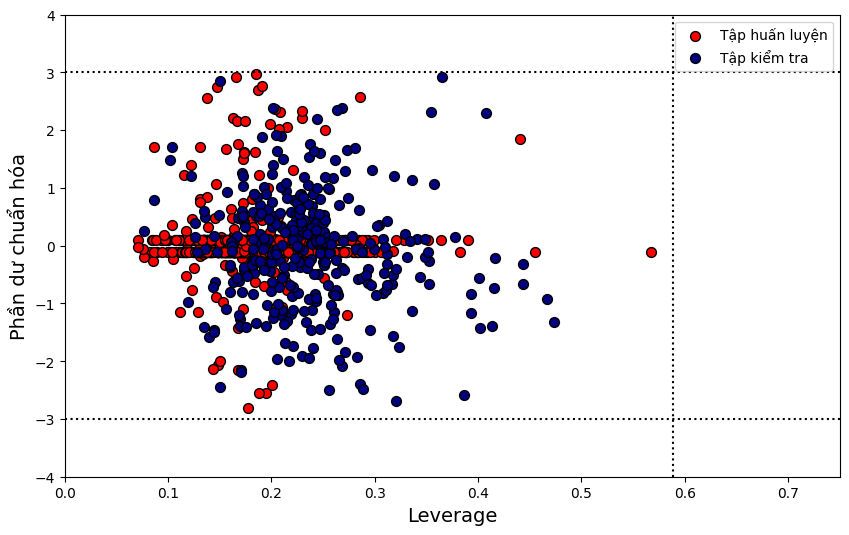

In [384]:
x_axis = y_train['leverage']
y_axis = y_train['standard']

x_axis_1 = y_test['leverage']
y_axis_1 = y_test['standard']


plt.figure(figsize=(10, 6))

plt.scatter(x_axis, y_axis, color = 'red', label = 'Tập huấn luyện', marker='o', s=50, edgecolors='black')
plt.scatter(x_axis_1, y_axis_1, color = 'navy', label = 'Tập kiểm tra', marker='o', s=50, edgecolors='black')

plt.xlabel('Leverage', fontsize = 14)
plt.ylabel('Phần dư chuẩn hóa', fontsize =14)
# plt.title('Applicability domain')
plt.xlim(0, 0.75)  # Set the x-axis limits
plt.ylim(-4, 4)  # Set the y-axis limits
plt.axhline(y = 3, color='black', linestyle='dotted')
plt.axhline(y = -3, color='black', linestyle='dotted')
plt.axvline(x =0.5889999, color='black', linestyle='dotted')
legend = plt.legend( loc='upper right', fontsize=10)
plt.show()

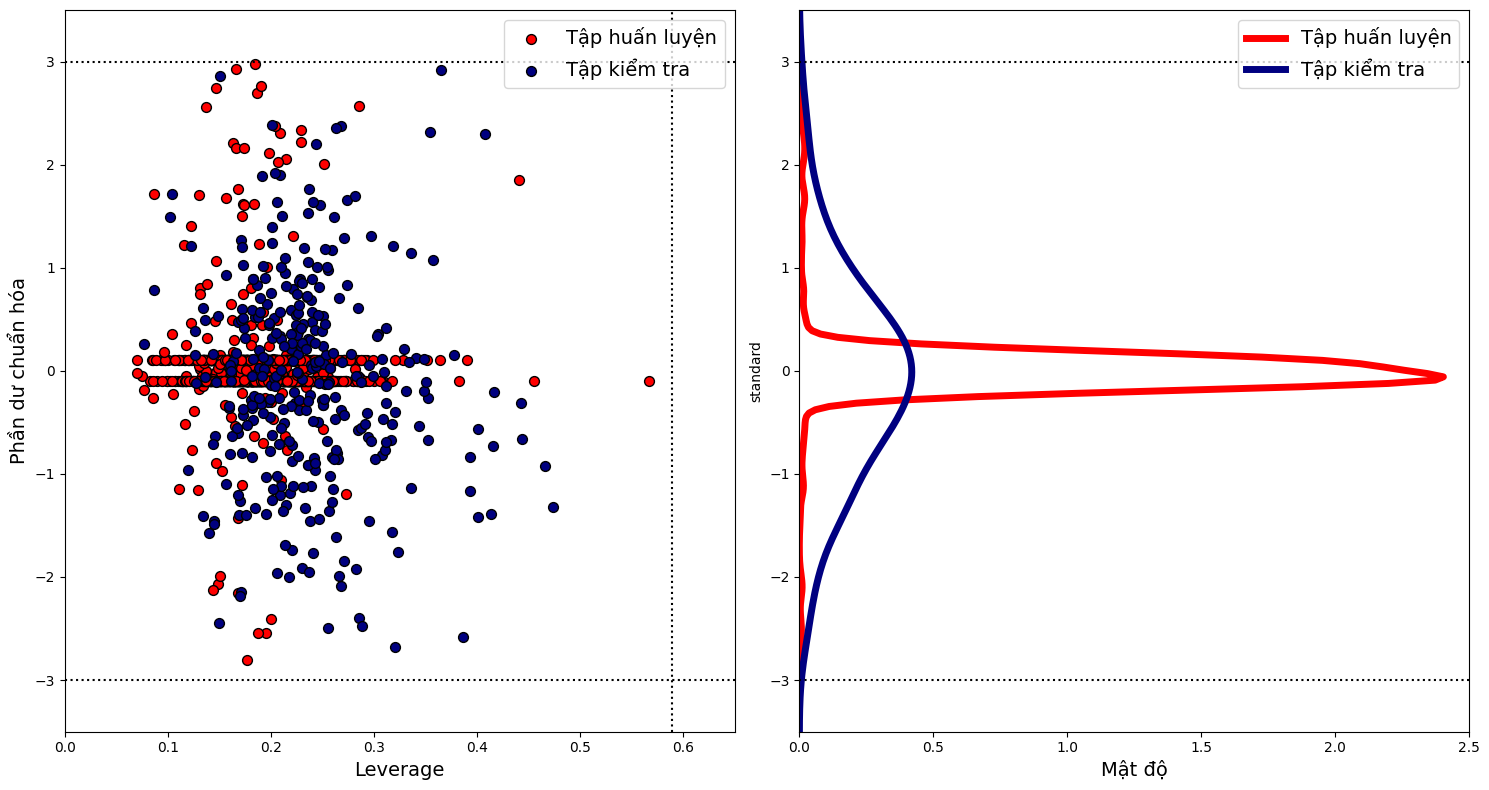

In [32]:
x_axis = y_train['leverage']
y_axis = y_train['standard']
x_axis_1 = y_test['leverage']
y_axis_1 = y_test['standard']

plt.figure(figsize=(15, 8))

# Scatter plot (left side)
plt.subplot(1, 2, 1)
plt.scatter(x_axis, y_axis, color='red', label='Tập huấn luyện', marker='o', s=50, edgecolors='black')
plt.scatter(x_axis_1, y_axis_1, color='navy', label='Tập kiểm tra', marker='o', s=50, edgecolors='black')
plt.xlabel('Leverage', fontsize=14)
plt.ylabel('Phần dư chuẩn hóa', fontsize=14)
plt.xlim(0, 0.65)
plt.ylim(-3.5, 3.5)
plt.axhline(y=3, color='black', linestyle='dotted')
plt.axhline(y=-3, color='black', linestyle='dotted')
plt.axvline(x =0.5889999, color='black', linestyle='dotted')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(loc='upper right', fontsize=14)


# KDE plot (right side)
plt.subplot(1, 2, 2)
sns.kdeplot(y_axis, color='red', linewidth=5, vertical=True, label='Tập huấn luyện')
sns.kdeplot(y_axis_1, color='navy', linewidth=5, vertical=True, label='Tập kiểm tra')
plt.xlabel('Mật độ', fontsize=14)
plt.ylim(-3.5,3.5)
plt.xlim(0, 2.5)
plt.axhline(y=3, color='black', linestyle='dotted')
plt.axhline(y=-3, color='black', linestyle='dotted')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(loc='upper right', fontsize=14)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

# 4. Y-SCRAMBLING TEST

In [345]:
def perform_y_scrambling(model, X_train, X_val, Y_train, Y_val, num_iterations=100):
   original_score = model.fit(X_train, Y_train).score(X_val, Y_val)
   original_r2 = r2_score(Y_val, model.predict(X_val))
   print("Original Model Score:", original_score)
   print("Original R^2:", original_r2)

   scores = []
   r2_values = []
   for i in range(num_iterations):
      Y_train_scrambled = shuffle(Y_train)  # Shuffle the target variable
      score = np.mean(cross_val_score(model, X_train, Y_train_scrambled, cv=10, scoring='r2', verbose = 2))
      r2 = r2_score(Y_val, model.predict(X_val))
      scores.append(score)
      r2_values.append(r2)

   avg_score = np.mean(scores)
   avg_r2 = np.mean(r2_values)
   print("Y Scrambling Average Score:", avg_score)
   print("Y Scrambling Average R^2:", avg_r2)

   print(scores)
   print(r2_values)

In [346]:
perform_y_scrambling(svr, X_train, X_train, y_train, y_train, num_iterations=100)

Original Model Score: 0.9920768567348833
Original R^2: 0.9920768567348833
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END ..........................

In [347]:
def perform_y_scrambling_r2(model, X_train, X_val, Y_train, Y_val, num_iterations=10):
   original_score = model.fit(X_train, Y_train).score(X_val, Y_val)
   original_r2 = r2_score(Y_val, model.predict(X_val))
   print("Original Model Score:", original_score)
   print("Original R^2:", original_r2)

   scores = []

   for i in range(num_iterations):
      Y_train_scrambled = shuffle(Y_train)  # Shuffle the target variable
      model.fit(X_train, Y_train_scrambled)  # Retrain the model on scrambled data
      score = model.score(X_val, Y_val)
      scores.append(score)

   avg_score = np.mean(scores)

   print("Y Scrambling Average Score:", avg_score)

   print(scores)

In [348]:
perform_y_scrambling_r2(svr, X_train, X_train, y_train, y_train, num_iterations=100)

Original Model Score: 0.9920768567348833
Original R^2: 0.9920768567348833
Y Scrambling Average Score: -0.48702103433724026
[-0.5422730736513539, -0.5048670782892459, -0.512700443493239, -0.6246843603203407, -0.4083477024348725, -0.566316254201676, -0.506489178773349, -0.4764544336848364, -0.5474843108094121, -0.4237940375434477, -0.41465924233952767, -0.4471560363638063, -0.5694094649362886, -0.46827148314211686, -0.4478090706263236, -0.3446986703653685, -0.5579178310557431, -0.4646419255413019, -0.4232990650171351, -0.5625259840516263, -0.556650069379486, -0.5340589014862915, -0.44654232274566197, -0.4226517154941245, -0.467360692023036, -0.40364604591151476, -0.5160506819765931, -0.6348914577204645, -0.5056848826426719, -0.43197455850854505, -0.5086684639183372, -0.4876005783432589, -0.502648736152562, -0.40982535442989576, -0.5132404592325635, -0.4991670007542319, -0.5510182965577475, -0.4477139045032954, -0.4812199247624709, -0.519365417437835, -0.5863686441825089, -0.4129813934262

# 5. RESULTS

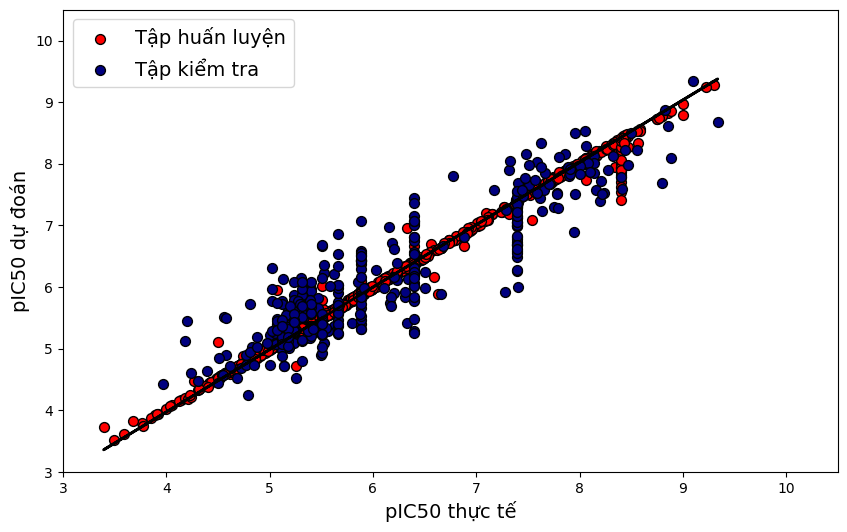

In [441]:
import numpy as np
import matplotlib.pyplot as plt

x_axis = y_train['pIC50']
y_axis = y_train['pred']

x_axis1 = y_test['pIC50']
y_axis1 = y_test['pred']

# Concatenate the data
x_combined = np.concatenate((x_axis, x_axis1))
y_combined = np.concatenate((y_axis, y_axis1))

plt.figure(figsize=(10, 6))

plt.scatter(x_axis, y_axis, color='red', label='Tập huấn luyện', marker='o', s=50, edgecolors='black')
plt.scatter(x_axis1, y_axis1, color='navy', label='Tập kiểm tra', marker='o', s=50, edgecolors='black')

slope, intercept = np.polyfit(y_combined, x_combined, 1)
best_fit_line = slope * x_combined + intercept
plt.plot(x_combined, best_fit_line, color='black', linewidth=2.0)

plt.xlabel('pIC50 thực tế', fontsize=14)
plt.ylabel('pIC50 dự đoán', fontsize=14)
plt.xlim(3, 10.5)  # Set the x-axis limits
plt.ylim(3, 10.5)  # Set the y-axis limits

legend = plt.legend(loc='upper left', fontsize=14)
plt.show()

# 6. PERMUTATION IMPORTANCE

In [155]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
perm_importance = permutation_importance(svr, X_test, y_test)

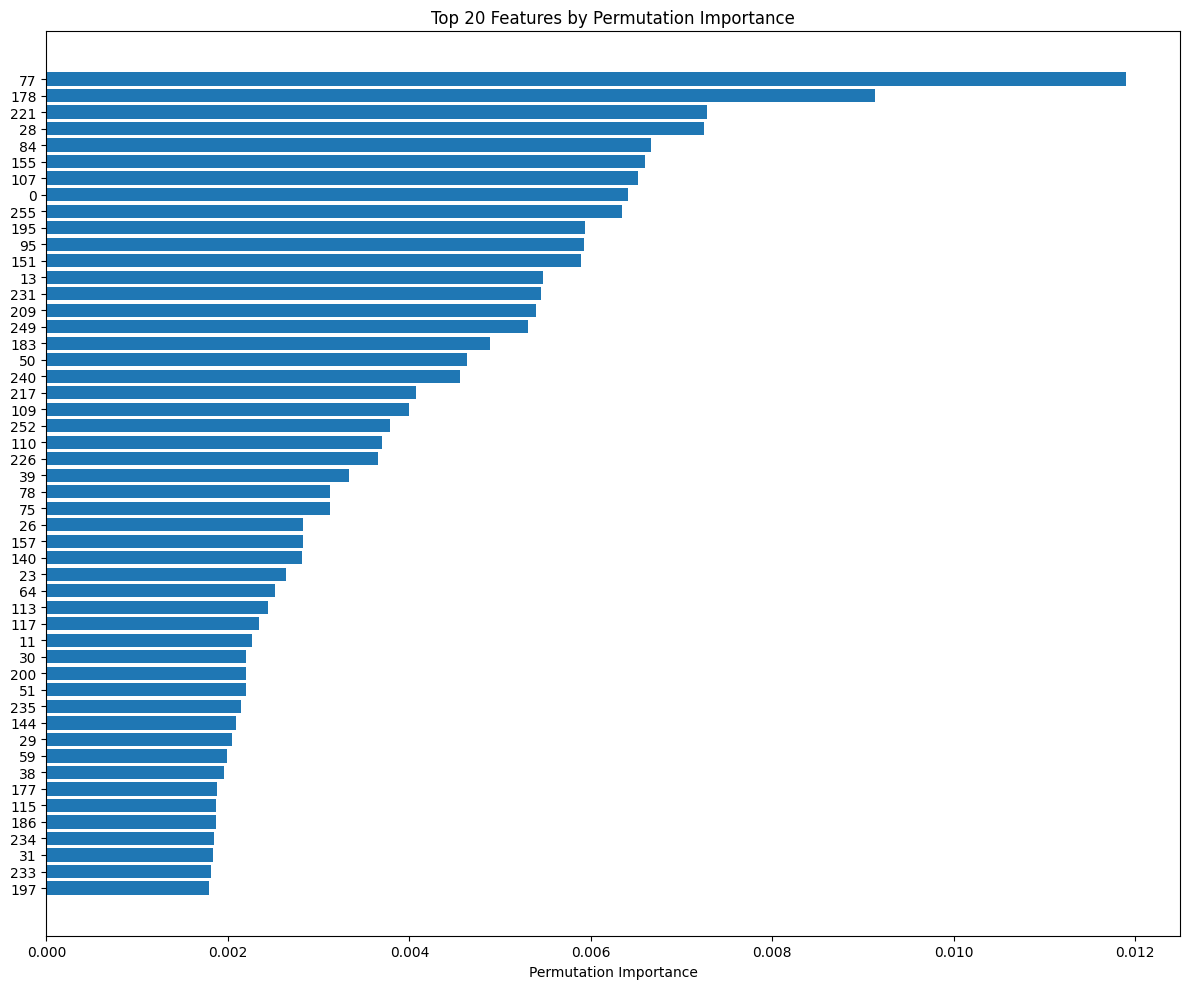

In [159]:
top_indices = np.argsort(perm_importance.importances_mean)[-50:]

# Get the importance scores and feature names for the top 20 features
top_importances = perm_importance.importances_mean[top_indices]
top_feature_names = X_test_new.columns[top_indices]

# Plotting the column graph
plt.figure(figsize=(12, 10))
plt.barh(range(len(top_importances)), top_importances, align='center')
plt.yticks(range(len(top_importances)), top_feature_names)
plt.xlabel('Permutation Importance')
plt.title('Top 20 Features by Permutation Importance')
plt.tight_layout()
plt.show()

66


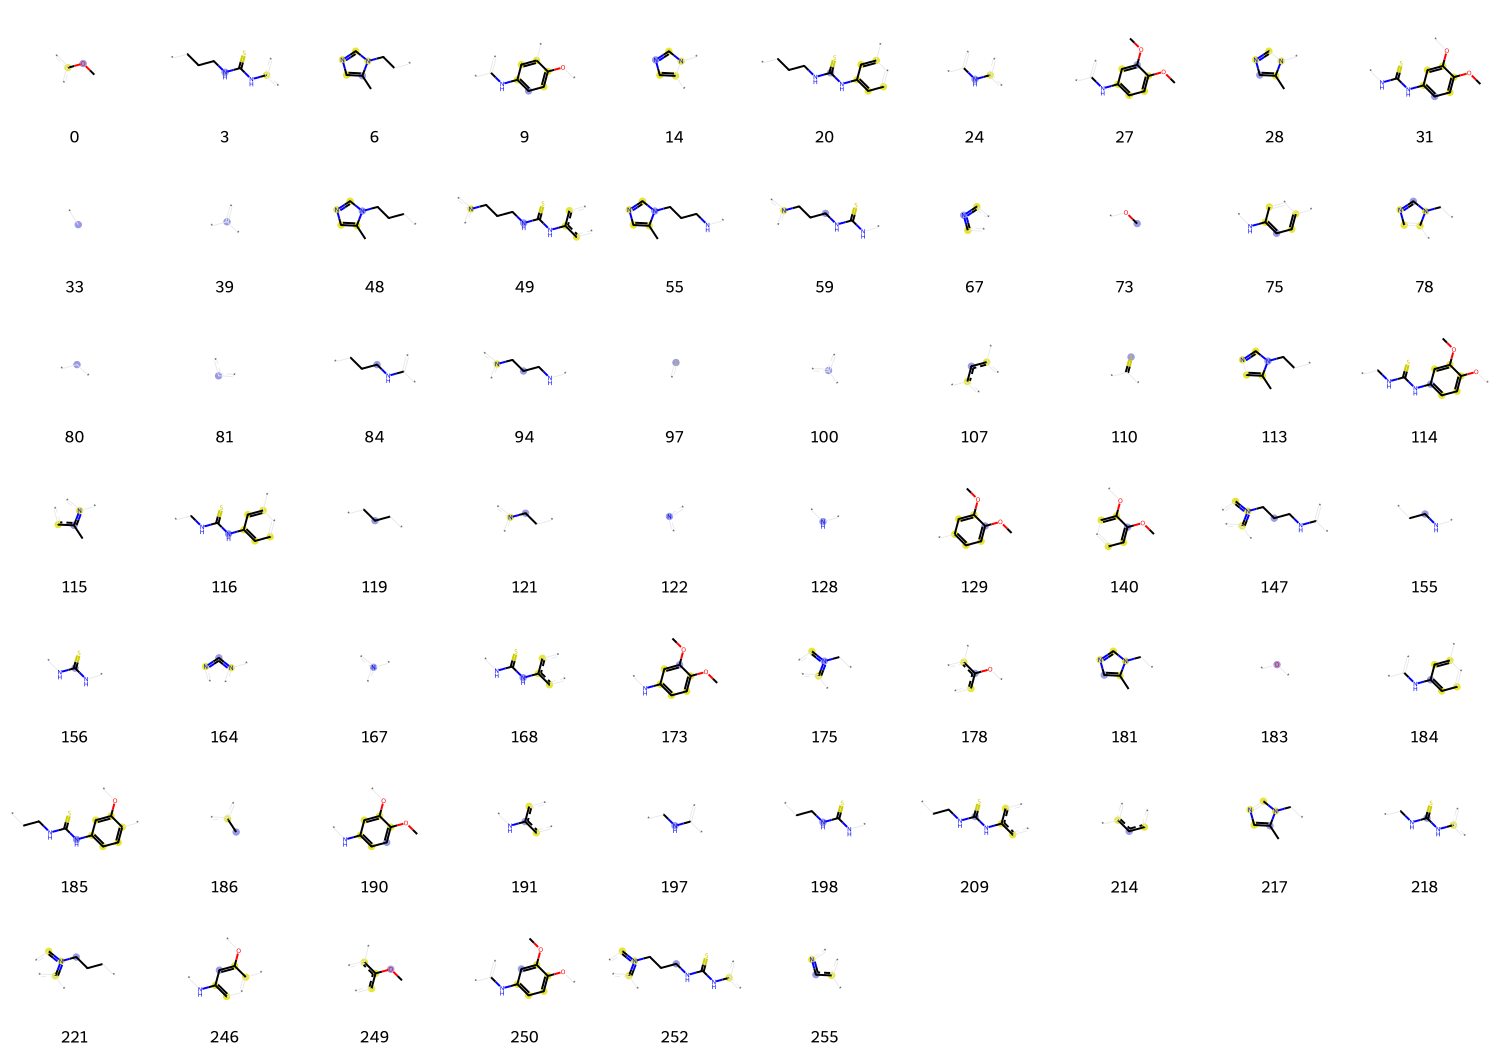

In [161]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

mol = Chem.MolFromSmiles('S=C(NCCCN1C(C)=CN=C1)NC2=CC=C(OC)C(OC)=C2')

bi1 = {}
fp1 = AllChem.GetMorganFingerprintAsBitVect(mol, radius=4, nBits = 256, bitInfo=bi1)

print(len(list(fp1.GetOnBits())))

tpls1 = [(mol, x, bi1) for x in fp1.GetOnBits()]
Draw.DrawMorganBits(tpls1[:], molsPerRow=10, legends=[str(x) for x in fp1.GetOnBits()][:])